In [ ]:
!pip install gurobipy
!pip install cartopy




Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 144 rows, 127 columns and 683 nonzeros
Model fingerprint: 0x00548b33
Model has 10 quadratic objective terms
Variable types: 6 continuous, 121 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+11]
  Objective range  [1e+00, 4e+08]
  QObjective range [4e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 13 rows and 0 columns
Presolve time: 0.00s
Presolved: 141 rows, 137 columns, 496 nonzeros
Variable types: 0 continuous, 137 integer (13 binary)
Found heuristic solution: objective 5.447273e+08

Root relaxation: objective 1.690628e+08, 27 iterations, 0.00 seconds

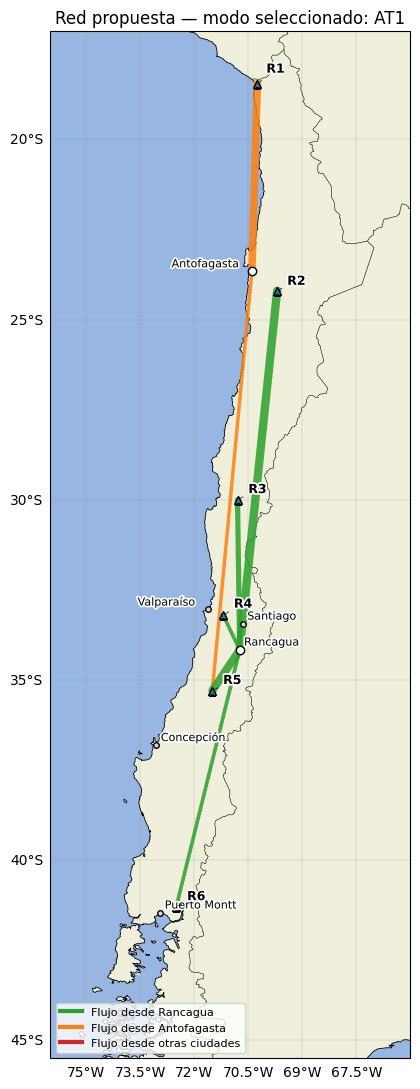

In [ ]:
from gurobipy import Model, GRB, quicksum
# --- Mapa con Cartopy ---
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Datos del problema
regiones = ["R1", "R2", "R3", "R4", "R5", "R6"]
ciudades = ["Antofagasta", "Valparaíso", "Santiago", "Concepción", "Puerto Montt", "Rancagua"]
ciudades_nuevas = ["Antofagasta", "Valparaíso", "Santiago", "Concepción", "Puerto Montt"]
tipos_planta = ["Pequeña", "Grande"]
transportes = ["AT1", "AT2", "AT3"]
años = [1, 2, 3]

# Parámetros
demanda_actual = {
    "R1": 951776, "R2": 967364, "R3": 512051, "R4": 386248, "R5": 946174, "R6": 303445
}
tasas_crecimiento = {
    "R1": 0.16, "R2": 0.22, "R3": 0.26, "R4": 0.15, "R5": 0.39, "R6": 0.30
}
capacidad_planta = {"Pequeña": 4636446, "Grande": 14966773}
costos_fijos = {
    ("Antofagasta", "Pequeña"): 18236639, ("Antofagasta", "Grande"): 60788796,
    ("Valparaíso", "Pequeña"): 8838286, ("Valparaíso", "Grande"): 32734393,
    ("Santiago", "Pequeña"): 6840758, ("Santiago", "Grande"): 32575039,
    ("Rancagua", "Pequeña"): 13378246, ("Rancagua", "Grande"): 53512984,
    ("Concepción", "Pequeña"): 26394217, ("Concepción", "Grande"): 65985543,
    ("Puerto Montt", "Pequeña"): 3678737, ("Puerto Montt", "Grande"): 26276695
}
costos_variables = {
    ("Antofagasta", "Pequeña"): 28.20, ("Antofagasta", "Grande"): 28.20,
    ("Valparaíso", "Pequeña"): 41.68, ("Valparaíso", "Grande"): 41.68,
    ("Santiago", "Pequeña"): 18.57, ("Santiago", "Grande"): 18.57,
    ("Rancagua", "Pequeña"): 17.68, ("Rancagua", "Grande"): 17.68,
    ("Concepción", "Pequeña"): 50.11, ("Concepción", "Grande"): 50.11,
    ("Puerto Montt", "Pequeña"): 43.55, ("Puerto Montt", "Grande"): 43.55
}
costos_apertura = {
    ("Antofagasta", "Pequeña"): 86626147, ("Antofagasta", "Grande"): 201456157,
    ("Valparaíso", "Pequeña"): 115721215, ("Valparaíso", "Grande"): 199519337,
    ("Santiago", "Pequeña"): 172235977, ("Santiago", "Grande"): 291925385,
    ("Rancagua", "Pequeña"): 0, ("Rancagua", "Grande"): 299031830,
    ("Concepción", "Pequeña"): 57494934, ("Concepción", "Grande"): 179671671,
    ("Puerto Montt", "Pequeña"): 175561277, ("Puerto Montt", "Grande"): 337617842
}
costos_transporte = {
    ("AT1", "Antofagasta", "R1"): 1.06, ("AT1", "Antofagasta", "R2"): 2.80, ("AT1", "Antofagasta", "R3"): 10.29,
    ("AT1", "Antofagasta", "R4"): 4.87, ("AT1", "Antofagasta", "R5"): 6.41, ("AT1", "Antofagasta", "R6"): 10.35,
    ("AT1", "Valparaíso", "R1"): 3.49, ("AT1", "Valparaíso", "R2"): 6.19, ("AT1", "Valparaíso", "R3"): 3.39,
    ("AT1", "Valparaíso", "R4"): 6.77, ("AT1", "Valparaíso", "R5"): 3.07, ("AT1", "Valparaíso", "R6"): 6.61,
    ("AT1", "Santiago", "R1"): 6.38, ("AT1", "Santiago", "R2"): 5.88, ("AT1", "Santiago", "R3"): 5.63,
    ("AT1", "Santiago", "R4"): 1.01, ("AT1", "Santiago", "R5"): 3.15, ("AT1", "Santiago", "R6"): 5.67,
    ("AT1", "Rancagua", "R1"): 3.44, ("AT1", "Rancagua", "R2"): 1.48, ("AT1", "Rancagua", "R3"): 2.79,
    ("AT1", "Rancagua", "R4"): 2.80, ("AT1", "Rancagua", "R5"): 5.30, ("AT1", "Rancagua", "R6"): 1.29,
    ("AT1", "Concepción", "R1"): 5.94, ("AT1", "Concepción", "R2"): 7.33, ("AT1", "Concepción", "R3"): 1.80,
    ("AT1", "Concepción", "R4"): 9.48, ("AT1", "Concepción", "R5"): 2.82, ("AT1", "Concepción", "R6"): 8.25,
    ("AT1", "Puerto Montt", "R1"): 2.57, ("AT1", "Puerto Montt", "R2"): 9.63, ("AT1", "Puerto Montt", "R3"): 4.84,
    ("AT1", "Puerto Montt", "R4"): 6.64, ("AT1", "Puerto Montt", "R5"): 6.48, ("AT1", "Puerto Montt", "R6"): 8.54,
    ("AT2", "Antofagasta", "R1"): 10.03, ("AT2", "Antofagasta", "R2"): 4.09, ("AT2", "Antofagasta", "R3"): 4.55,
    ("AT2", "Antofagasta", "R4"): 7.84, ("AT2", "Antofagasta", "R5"): 5.33, ("AT2", "Antofagasta", "R6"): 10.63,
    ("AT2", "Valparaíso", "R1"): 10.52, ("AT2", "Valparaíso", "R2"): 1.82, ("AT2", "Valparaíso", "R3"): 3.91,
    ("AT2", "Valparaíso", "R4"): 8.20, ("AT2", "Valparaíso", "R5"): 5.88, ("AT2", "Valparaíso", "R6"): 2.33,
    ("AT2", "Santiago", "R1"): 1.90, ("AT2", "Santiago", "R2"): 8.89, ("AT2", "Santiago", "R3"): 6.55,
    ("AT2", "Santiago", "R4"): 9.71, ("AT2", "Santiago", "R5"): 7.03, ("AT2", "Santiago", "R6"): 10.23,
    ("AT2", "Rancagua", "R1"): 2.06, ("AT2", "Rancagua", "R2"): 10.17, ("AT2", "Rancagua", "R3"): 2.12,
    ("AT2", "Rancagua", "R4"): 6.11, ("AT2", "Rancagua", "R5"): 3.79, ("AT2", "Rancagua", "R6"): 6.19,
    ("AT2", "Concepción", "R1"): 2.54, ("AT2", "Concepción", "R2"): 6.95, ("AT2", "Concepción", "R3"): 8.57,
    ("AT2", "Concepción", "R4"): 10.50, ("AT2", "Concepción", "R5"): 4.85, ("AT2", "Concepción", "R6"): 5.31,
    ("AT2", "Puerto Montt", "R1"): 7.92, ("AT2", "Puerto Montt", "R2"): 10.32, ("AT2", "Puerto Montt", "R3"): 1.41,
    ("AT2", "Puerto Montt", "R4"): 4.94, ("AT2", "Puerto Montt", "R5"): 2.74, ("AT2", "Puerto Montt", "R6"): 8.08,
    ("AT3", "Antofagasta", "R1"): 9.86, ("AT3", "Antofagasta", "R2"): 4.30, ("AT3", "Antofagasta", "R3"): 8.10,
    ("AT3", "Antofagasta", "R4"): 9.63, ("AT3", "Antofagasta", "R5"): 7.40, ("AT3", "Antofagasta", "R6"): 6.47,
    ("AT3", "Valparaíso", "R1"): 1.58, ("AT3", "Valparaíso", "R2"): 2.71, ("AT3", "Valparaíso", "R3"): 3.08,
    ("AT3", "Valparaíso", "R4"): 5.91, ("AT3", "Valparaíso", "R5"): 7.99, ("AT3", "Valparaíso", "R6"): 5.11,
    ("AT3", "Santiago", "R1"): 9.13, ("AT3", "Santiago", "R2"): 10.03, ("AT3", "Santiago", "R3"): 6.77,
    ("AT3", "Santiago", "R4"): 5.70, ("AT3", "Santiago", "R5"): 3.62, ("AT3", "Santiago", "R6"): 8.58,
    ("AT3", "Rancagua", "R1"): 8.95, ("AT3", "Rancagua", "R2"): 7.37, ("AT3", "Rancagua", "R3"): 10.29,
    ("AT3", "Rancagua", "R4"): 3.34, ("AT3", "Rancagua", "R5"): 2.21, ("AT3", "Rancagua", "R6"): 4.58,
    ("AT3", "Concepción", "R1"): 9.62, ("AT3", "Concepción", "R2"): 3.78, ("AT3", "Concepción", "R3"): 5.19,
    ("AT3", "Concepción", "R4"): 2.61, ("AT3", "Concepción", "R5"): 3.19, ("AT3", "Concepción", "R6"): 1.78,
    ("AT3", "Puerto Montt", "R1"): 10.32, ("AT3", "Puerto Montt", "R2"): 8.88, ("AT3", "Puerto Montt", "R3"): 10.87,
    ("AT3", "Puerto Montt", "R4"): 10.38, ("AT3", "Puerto Montt", "R5"): 5.83, ("AT3", "Puerto Montt", "R6"): 1.54
}

# Crear el modelo
m = Model("FunnysCompany")

# Variables de decisión
# Variable binaria para la instalación de plantas en las ciudades candidatas
x = m.addVars(ciudades_nuevas, tipos_planta, vtype=GRB.BINARY, name="x")

# Variable binaria para la selección del tipo de transporte
z = m.addVars(transportes, vtype=GRB.BINARY, name="z")

# Variable entera para el flujo de productos (unidades totales en 3 años)
y = m.addVars(ciudades, regiones, transportes, vtype=GRB.INTEGER, name="y")

# Variable continua para la producción anual total de cada planta (unidades totales en 3 años)
produccion = m.addVars(ciudades, vtype=GRB.CONTINUOUS, name="produccion")

# Función objetivo
m.setObjective(
    # Costos de apertura (solo para nuevas plantas)
    quicksum(costos_apertura[(c, p)] * x[c, p] for c in ciudades_nuevas for p in tipos_planta) +

    # Costos fijos anuales (para 3 años)
    (quicksum(costos_fijos[(c, p)] * x[c, p] for c in ciudades_nuevas for p in tipos_planta) +
     costos_fijos[("Rancagua", "Pequeña")]) * 3 +

    # Costos variables
    costos_variables[("Rancagua", "Pequeña")] * produccion["Rancagua"] +
    quicksum(costos_variables[(c, p)] * produccion[c] * x[c,p] for c in ciudades_nuevas for p in tipos_planta) +

    # Costos de transporte
    quicksum(costos_transporte[(t, c, r)] * y[c, r, t] for c in ciudades for r in regiones for t in transportes),
    GRB.MINIMIZE
)

# Restricciones
# 1. Cada región debe satisfacer su demanda total proyectada para los 3 años
for r in regiones:
    for an in años:
        demanda_proyectada = demanda_actual[r] * (1 + tasas_crecimiento[r]) ** (an - 1)
        m.addConstr(quicksum(y[c, r, t] for c in ciudades for t in transportes) >= demanda_proyectada, name=f"demanda_satisfecha_{r}_año_{an}")

# 2. Restricción de capacidad para cada planta (para 3 años)
for c in ciudades:
  if c == "Rancagua":
    m.addConstr(produccion[c] <= capacidad_planta["Pequeña"], name=f"capacidad_planta_{c}")
  else:
    m.addConstr(produccion[c] <= quicksum(capacidad_planta[p] * x[c, p] for p in tipos_planta), name=f"capacidad_planta_{c}")

# 3. La producción total debe ser igual al transporte total para cada planta
for c in ciudades:
    m.addConstr(produccion[c] == quicksum(y[c, r, t] for r in regiones for t in transportes), name=f"produccion_transporte_{c}")

# 4. Se debe elegir solo un tipo de planta en cada ciudad candidata (o ninguna)
for c in ciudades_nuevas:
    m.addConstr(quicksum(x[c, p] for p in tipos_planta) <= 1, name=f"una_planta_por_ciudad_{c}")

# 5. Se debe elegir solo una alternativa de transporte
m.addConstr(quicksum(z[t] for t in transportes) == 1, name="un_transporte_elegido")

# 6. La variable de flujo de transporte 'y' solo puede ser positiva si el transporte 't' es elegido
# Se utiliza una M grande (un número muy grande) para activar el flujo solo si z[t] es 1.
M = 100000000000
for c in ciudades:
    for r in regiones:
        for t in transportes:
            m.addConstr(y[c, r, t] <= M * z[t], name=f"flujo_condicional_{c}_{r}_{t}")
# Coordenadas aproximadas (lat, lon)
coords_ciudades = {
    "Antofagasta": (-23.65, -70.40),
    "Valparaíso":  (-33.04, -71.62),
    "Santiago":    (-33.45, -70.65),
    "Concepción":  (-36.82, -73.05),
    "Puerto Montt":(-41.47, -72.94),
    "Rancagua":    (-34.17, -70.74),
}

# Puedes ubicar las regiones en capitales/centroides aproximados
coords_regiones = {
    "R1": (-18.48, -70.30),  # Arica/Parinacota aprox
    "R2": (-23.65, -70.40),  # Antofagasta aprox
    "R3": (-29.90, -71.25),  # Coquimbo/La Serena aprox
    "R4": (-33.04, -71.62),  # Valparaíso aprox
    "R5": (-35.42, -71.66),  # Maule/Talca aprox
    "R6": (-41.47, -72.94),  # Los Lagos/Pto. Montt aprox
}

# Optimizar el modelo
m.optimize()

# Mostrar resultados
if m.status == GRB.OPTIMAL:
    print("\n--- Resultados del Modelo ---")
    print(f"Costo Total General: ${m.objVal:,.2f}")

    print("\n--- Plan de Configuración de Plantas ---")
    for c in ciudades:
        for p in tipos_planta:
            if c != "Rancagua" and x[c, p].X > 0.5:
                print(f"Instalar planta {p} en {c}")
    print("La planta de Rancagua ya existe y es de tipo pequeña.")

    print("\n--- Servicio de Transporte Seleccionado ---")
    for t in transportes:
        if z[t].X > 0.5:
            print(f"Transporte seleccionado: {t}")

    print("\n--- Costos Detallados ---")
    total_apertura = sum(costos_apertura[(c, p)] * x[c, p].X for c in ciudades_nuevas for p in tipos_planta)
    total_fijo = (sum(costos_fijos[(c, p)] * x[(c, p)].X for c in ciudades_nuevas for p in tipos_planta) + costos_fijos[("Rancagua", "Pequeña")]) * 3
    total_variable = sum(costos_variables[(c, "Pequeña")] * produccion[c].X for c in ciudades_nuevas if x.get(c, "Pequeña") and x[c, "Pequeña"].X > 0.5) + \
                     sum(costos_variables[(c, "Grande")] * produccion[c].X for c in ciudades_nuevas if x.get(c, "Grande") and x[c, "Grande"].X > 0.5) + \
                     costos_variables[("Rancagua", "Pequeña")] * produccion["Rancagua"].X

    total_transporte = sum(costos_transporte[(t, c, r)] * y[c, r, t].X for c in ciudades for r in regiones for t in transportes)

    print(f"Costo total de apertura: ${total_apertura:,.2f}")
    print(f"Costo total fijo (3 años): ${total_fijo:,.2f}")
    print(f"Costo total variable: ${total_variable:,.2f}")
    print(f"Costo total de transporte: ${total_transporte:,.2f}")

    print("\n--- Flujo de Transporte Total (3 años) ---")
    for c in ciudades:
        for r in regiones:
            for t in transportes:
                if y[c, r, t].X > 0:
                    print(f"Transportar {y[c, r, t].X:,.0f} unidades desde {c} a {r} usando {t}")
    # ========================
    # ====== MAPA (PNG) ======
    # ========================
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.patheffects as pe
    from matplotlib.lines import Line2D

    # --- centroides  ---
    coords_regiones = {
        "R1": (-18.45, -70.25),  # Arica-Parinacota
        "R2": (-24.20, -69.70),  # Antofagasta
        "R3": (-30.00, -70.80),  # Coquimbo/La Serena
        "R4": (-33.20, -71.20),  # Valparaíso
        "R5": (-35.30, -71.50),  # Maule/Talca
        "R6": (-41.30, -72.50),  # Los Lagos
    }

    # --- offsets de etiquetas: (lon_delta, lat_delta) ---
    offset_reg = {
        "R1": ( 0.25,  0.22),
        "R2": ( 0.28,  0.08),
        "R3": ( 0.30,  0.10),
        "R4": ( 0.30,  0.12),
        "R5": ( 0.30,  0.10),
        "R6": ( 0.30,  0.10),
    }

    # offsets de etiquetas de ciudades
    offset_city = {
        "Antofagasta": (-0.35,  0.10),
        "Valparaíso":  (-0.35,  0.10),
        "Santiago":    ( 0.12,  0.12),
        "Concepción":  ( 0.12,  0.12),
        "Puerto Montt":( 0.12,  0.12),
        "Rancagua":    ( 0.12,  0.12),
    }
    align_city = {
        "Antofagasta": "right",
        "Valparaíso":  "right",
        "Santiago":    "left",
        "Concepción":  "left",
        "Puerto Montt":"left",
        "Rancagua":    "left",
    }

    # modo seleccionado
    t_sel = max(transportes, key=lambda t: z[t].X)

    # flujos acumulados por ciudad->región
    flujos = {}
    max_qty = 0.0
    for c in ciudades:
        for r in regiones:
            qty = sum(y[c, r, t].X for t in transportes)
            if qty > 0:
                flujos[(c, r)] = qty
                max_qty = max(max_qty, qty)

    # grosor proporcional
    def ancho(q):
        if max_qty <= 0:
            return 1.0
        return 0.8 + 5.2 * (q / max_qty)

    # color por ORIGEN
    def color_origen(ciudad):
        if ciudad == "Rancagua":
            return "tab:green"
        if ciudad == "Antofagasta":
            return "tab:orange"
        return "tab:red"

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(8, 11))
    ax = plt.axes(projection=proj)
    ax.set_extent([-76, -66, -45.5, -17], crs=proj)

    # base
    ax.add_feature(cfeature.LAND, zorder=0)
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, zorder=3)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # dibujar líneas
    UMBRAL = 2e5
    for (c, r), qty in flujos.items():
        if qty >= UMBRAL:
            latc, lonc = coords_ciudades[c]
            latr, lonr = coords_regiones[r]
            col = color_origen(c)
            ax.plot([lonc, lonr], [latc, latr], transform=proj,
                    linewidth=ancho(qty), color=col, alpha=0.85, zorder=4, solid_capstyle="round")
            # puntos para que "toque" visualmente origen y destino
            ax.plot(lonc, latc, transform=proj, marker="o", markersize=3.2, color=col, zorder=5)
            ax.plot(lonr, latr, transform=proj, marker="o", markersize=3.2, color=col, zorder=5)

    # ciudades (marcador + etiqueta con offset/align)
    for c in ciudades:
        lat, lon = coords_ciudades[c]
        abierta = (c == "Rancagua") or any(x[c, p].X > 0.5 for p in tipos_planta if c in ciudades_nuevas)
        ax.plot(lon, lat, transform=proj, marker="o",
                markersize=6 if abierta else 4,
                markerfacecolor=("white" if abierta else "lightgray"),
                markeredgecolor="black", linewidth=0.5, zorder=6)
        dx, dy = offset_city.get(c, (0.12, 0.12))
        ha = align_city.get(c, "left")
        ax.text(lon + dx, lat + dy, c, transform=proj, fontsize=8, ha=ha,
                zorder=7, clip_on=False,
                path_effects=[pe.withStroke(linewidth=2.5, foreground="white")])

    # regiones (triángulo + etiqueta desplazada con flecha)
    for r in regiones:
        lat, lon = coords_regiones[r]
        ax.plot(lon, lat, transform=proj, marker="^", markersize=6,
                markerfacecolor="tab:blue", markeredgecolor="black", linewidth=0.5, zorder=6)
        dx, dy = offset_reg.get(r, (0.25, 0.15))
        ax.annotate(
            r, xy=(lon, lat), xytext=(lon + dx, lat + dy),
            textcoords=proj, xycoords=proj,
            fontsize=9, weight="bold", zorder=7, ha="left", va="bottom",
            path_effects=[pe.withStroke(linewidth=2.5, foreground="white")],
            arrowprops=dict(arrowstyle="-", lw=0.6, color="black", alpha=0.8)
        )

    # leyenda
    legend_elems = [
        Line2D([0], [0], color="tab:green",  lw=3, label="Flujo desde Rancagua"),
        Line2D([0], [0], color="tab:orange", lw=3, label="Flujo desde Antofagasta"),
        Line2D([0], [0], color="tab:red",    lw=3, label="Flujo desde otras ciudades"),
    ]
    ax.legend(handles=legend_elems, loc="lower left", fontsize=8)

    plt.title(f"Red propuesta — modo seleccionado: {t_sel}", fontsize=12)
    plt.tight_layout()
    plt.savefig("mapa_cartopy.png", dpi=220, bbox_inches="tight")
    print("Mapa guardado en mapa_cartopy.png")


else:
    print("El modelo no tiene solución óptima.")
